In [203]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.constants as const

from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import interp1d


## Establish baseline costs
Largely dervied from [this paper](https://www.researchgate.net/publication/341420273_Cost_Analysis_of_Direct_Air_Capture_and_Sequestration_Coupled_to_Low-Carbon_Thermal_Energy_in_the_US)

In [303]:
costs = {
    "capex": {
        "2018": {
            "contactor": 111.48,
            "fan": 6.48,
            "vacuum_pump": 5.08,
            "heat_exchanger": 1.97
        }
    },
    "opex": {
        "2018": {
            "fan": 16.26,
            "vacuum_pump": 12.19,
            "compression": 6.63,
            "maintenance": 23.96,
            "labor": 7.27,
            "steam": 22.68
        }
    }
}

compression_capex = 6.00 # McQueen et al 2020 supplement pg 21
trucking_capex = 9.01 - compression_capex

costs["capex"]["2018"]["compression"] = compression_capex
costs["capex"]["2018"]["trucking"] = trucking_capex

base_capex_2018 = sum(costs["capex"]["2018"].values())
base_opex_2018 = sum(costs["opex"]["2018"].values())

print(f"Verified: ${base_capex_2018:.2f} capex, ${base_opex_2018:.2f} opex (to gate) matches McQueen et al 2020")

# McQueen et al 2020 doesn't include storage costs; midpoint of DOE, 2014 estimate ($7-13) used (see ch.7 http://nap.nationalacademies.org/25259)
costs["opex"]["2018"]["storage"] = 10.00

base_opex_2018_to_grave = sum(costs["opex"]["2018"].values())
print(f"To grave opex is ${base_opex_2018_to_grave:.2f}")

Verified: $134.02 capex, $88.99 opex (to gate) matches McQueen et al 2020
To grave opex is $98.99


#### Forecast baseline to 2030

In [314]:
def forecast_improvement(start_value, rate, start_year, direction="decrease", end_year=2030):
    if direction == "decrease":
        end_value = start_value * (1 - rate) ** (end_year - start_year)
    else:
        end_value = start_value * (1 + rate) ** (end_year - start_year)
    return end_value

# Unless otherwise specified, all improvement rates are from supplement to https://pubs.rsc.org/en/content/articlelanding/2019/ee/c9ee01526d 
adsorption_ir_lower = 0.033097
adsorption_ir_mean = 0.1172984
adsorption_ir = (adsorption_ir_lower + adsorption_ir_mean) / 2

contactor_capex_2030 = forecast_improvement(costs["capex"]["2018"]["contactor"], adsorption_ir, 2018)

costs["capex"]["2030"] = {
    "contactor": contactor_capex_2030,
    "fan": costs["capex"]["2018"]["fan"],
    "vacuum_pump": costs["capex"]["2018"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2018"]["heat_exchanger"],
    "compression": costs["capex"]["2018"]["compression"],
    "trucking": costs["capex"]["2018"]["trucking"]
}

print(f"Contactor capex forecast to decrease to ${contactor_capex_2030:.2f} in 2030, given improvement rate of {adsorption_ir:.2%}.")
print(f"No improvement assumed for other capex categories; baseline 2030 capex estimated at ${sum(costs['capex']['2030'].values()):.2f}.")

Contactor capex forecast to decrease to $43.63 in 2030, given improvement rate of 7.52%.
No improvement assumed for other capex categories; baseline 2030 capex estimated at $66.17.


In [321]:
nas_thermal_requirement_low = 3.4 # GJ/ton ch. 5 http://nap.nationalacademies.org/25259
an_et_al_thermal_requirement_high = 2.03 # https://www.osti.gov/pages/servlets/purl/2203824
thermal_requirement_2030 = (nas_thermal_requirement_low + an_et_al_thermal_requirement_high) / 2
steam_price = 2.9
base_steam_opex_2030 = thermal_requirement_2030 * steam_price
print(f"2030 baseline steam opex forecast to be ${base_steam_opex_2030:.2f}, given thermal requirement of {thermal_requirement_2030:.2f} GJ/ton.")

capex_2018 = sum(costs["capex"]["2018"].values())

mtc_fraction = costs["opex"]["2018"]["maintenance"] / capex_2018
base_mtc_opex_2030 = mtc_fraction * sum(costs["capex"]["2030"].values())

labor_fraction = costs["opex"]["2018"]["labor"] / capex_2018
base_labor_opex_2030 = labor_fraction * sum(costs["capex"]["2030"].values())
print(f"2030 baseline maintenance opex forecast to be ${base_mtc_opex_2030:.2f}, labor opex forecast to be ${base_labor_opex_2030:.2f} (uses 2018 "
      f"fractions).")

storage_ir = 0.013336
base_storage_opex_2030 = forecast_improvement(costs["opex"]["2018"]["storage"], storage_ir, 2013)
print(f"2030 baseline storage opex forecast to be ${base_storage_opex_2030:.2f}, given improvement rate of {storage_ir:.2%}.")

costs["opex"]["2030"] = {
    "fan": costs["opex"]["2018"]["fan"],
    "vacuum_pump": costs["opex"]["2018"]["vacuum_pump"],
    "compression": costs["opex"]["2018"]["compression"],
    "maintenance": base_mtc_opex_2030,
    "labor": base_labor_opex_2030,
    "steam": base_steam_opex_2030,
    "storage": base_storage_opex_2030
}

print(f"2030 baseline opex forecast to be ${sum(costs['opex']['2030'].values()):.2f}.")


2030 baseline steam opex forecast to be $7.87, given thermal requirement of 2.71 GJ/ton.
2030 baseline maintenance opex forecast to be $11.83, labor opex forecast to be $3.59 (uses 2018 fractions).
2030 baseline storage opex forecast to be $7.96, given improvement rate of 1.33%.
2030 baseline opex forecast to be $66.33.


In [324]:
total_base_cost_2018 = sum(costs["capex"]["2018"].values()) + sum(costs["opex"]["2018"].values())
total_base_cost_2030 = sum(costs["capex"]["2030"].values()) + sum(costs["opex"]["2030"].values())
print(f"Baseline 2018 total gross cost: ${total_base_cost_2018:.2f}, 2030 total gross cost: ${total_base_cost_2030:.2f}")

Baseline 2018 total gross cost: $233.01, 2030 total gross cost: $132.50


## Estimate baseline cost net of CO2 emissions from capture process

In [325]:
# US average electricity emissions from https://www.epa.gov/climateleadership/ghg-emission-factors-hub 
grid_intensities = {
    2014: 1232.35,
    2015: 1136.53,
    2018: 998.4,
    2020: 947.2,
    2021: 884.2,
    2022: 818.3,
    2023: 852.3,
    2024: 823.1
}

grid_intensities_df = pd.DataFrame(list(grid_intensities.items()), columns=["year", "grid_intensity_lb_per_MWh"])
grid_intensities_df["grid_intensity_g_per_kWh"] = grid_intensities_df["grid_intensity_lb_per_MWh"] * 453.592 / 1000
grid_intensities_df


,year,grid_intensity_lb_per_MWh,grid_intensity_g_per_kWh
0,2014,1232.35,558.984101
1,2015,1136.53,515.520916
2,2018,998.40,452.866253
3,2020,947.20,429.642342
4,2021,884.20,401.066046
5,2022,818.30,371.174334
6,2023,852.30,386.596462
7,2024,823.10,373.351575


#### Forecast 2030 grid intensities
Opted for linear regression over power law

Discarded: 2030 grid intensity forecasted to be 283.25 g/kWh using power law across 8 observations.


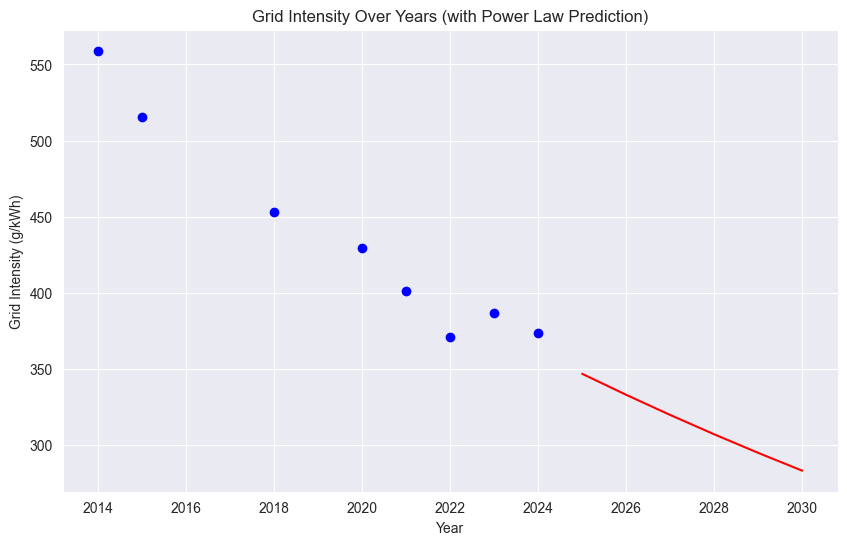

In [328]:
factors_X_log = np.log(grid_intensities_df['year'])
factors_y_log = np.log(grid_intensities_df['grid_intensity_g_per_kWh'])

model = LinearRegression()
model.fit(factors_X_log.values.reshape(-1, 1), factors_y_log.values)

future_years = np.array([2025, 2026, 2027, 2028, 2029, 2030])
log_predictions = model.predict(np.log(future_years).reshape(-1, 1))

transformed_predictions = np.exp(log_predictions)
unused_2030_grid_intensity = transformed_predictions[-1]
print(f"Discarded: 2030 grid intensity forecasted to be {unused_2030_grid_intensity:.2f} g/kWh using power law across 8 interrupted observations.")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(grid_intensities_df['year'], grid_intensities_df['grid_intensity_g_per_kWh'], color='blue')
plt.plot(future_years, predictions, color='red')
plt.title('Grid Intensity Over Years (with Power Law Prediction)')
plt.xlabel('Year')
plt.ylabel('Grid Intensity (g/kWh)')
plt.grid(True)
plt.show()

In [330]:
recent_grid_intensities_df = grid_intensities_df[grid_intensities_df['year'] >= 2020]

factors_X = recent_grid_intensities_df['year'].values.reshape(-1, 1)
factors_y = recent_grid_intensities_df['grid_intensity_g_per_kWh'].values

model = LinearRegression()
model.fit(factors_X, factors_y)

# Predict the value for 2030
pred_2030_grid_intensity = model.predict(np.array([[2030]]))[0]
print(f"2030 grid intensity forecasted to be {pred_2030_grid_intensity:.2f} g/kWh using linear regression on 5 most recent, uninterrupted observations.")

2030 grid intensity forecasted to be 290.73 g/kWh using linear regression on 5 most recent, uninterrupted observations.


#### Apply forecasted 2030 emissions factors

In [331]:
electrical_requirement = 1.5 # GJ/ton
gj_to_kwh = 277.778
electrical_requirement_kwh = electrical_requirement * gj_to_kwh

electric_co2_footprint_g = pred_2030_grid_intensity * electrical_requirement_kwh
print(f"Electricity CO2 footprint forecasted to be {electric_co2_footprint_g:.2f} g/ton in 2030.")
electric_co2_footprint = electric_co2_footprint_g / 1000000
electric_co2_footprint # ton/ton


Electricity CO2 footprint forecasted to be 121135.62 g/ton in 2030.


0.1211356204417522

In [249]:
paper_electric_co2_footprint_g = 490 * electrical_requirement_kwh
paper_electric_co2_footprint = paper_electric_co2_footprint_g / 1000000
paper_electric_co2_footprint # ton/ton

0.20416683000000002

In [250]:
heat_intensity = 227 # g/kWh
heat_requirement_kwh = thermal_requirement_2030 * gj_to_kwh

heat_co2_footprint_g = heat_intensity * heat_requirement_kwh
heat_co2_footprint = heat_co2_footprint_g / 1000000
heat_co2_footprint # ton/ton

0.17119597029

In [251]:
trucking_intensity = 0.168 # kg/ton-mile
trucking_unit_costs = 0.14 # $/ton-mile
trucking_units = trucking_capex / trucking_unit_costs

trucking_footprint_kg = trucking_intensity * trucking_units
trucking_footprint = trucking_footprint_kg / 1000
trucking_footprint # ton

0.0036119999999999998

In [252]:
trucking_intensity_2018 = 0.17
trucking_unit_costs_2018 = 0.14
trucking_units_2018 = trucking_capex / trucking_unit_costs_2018

trucking_footprint_kg_2018 = trucking_intensity_2018 * trucking_units_2018
trucking_footprint_2018 = trucking_footprint_kg_2018 / 1000

paper_mod_total_co2_footprint = .29
embodied_material_emissions = 0.29 - paper_electric_co2_footprint - trucking_footprint_2018
embodied_material_emissions

0.08217816999999995

In [253]:
total_co2_footprint = electric_co2_footprint + heat_co2_footprint + trucking_footprint + embodied_material_emissions
print(total_co2_footprint)
net_cost_2030 = total_cost_2030 / (1 - total_co2_footprint)
net_cost_2030

0.37812176073175213


215.324749360281

In [258]:
costs["opex"]["aero"] = {
    "fan": costs["opex"]["2030"]["fan"],
    "vacuum_pump": costs["opex"]["2030"]["vacuum_pump"],
    "compression": costs["opex"]["2030"]["compression"],
    "maintenance": costs["opex"]["2030"]["maintenance"],
    "labor": costs["opex"]["2030"]["labor"],
    "steam": costs["opex"]["2030"]["steam"],
    "storage": costs["opex"]["2030"]["storage"]
}
costs["capex"]["aero"] = {
    "contactor": costs["capex"]["2030"]["contactor"],
    "fan": costs["capex"]["2030"]["fan"],
    "vacuum_pump": costs["capex"]["2030"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2030"]["heat_exchanger"],
    "compression": costs["capex"]["2030"]["compression"],
    "trucking": costs["capex"]["2030"]["trucking"]
}
costs

{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 43.62985545245635,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  'aero': {'contactor': 43.62985545245635,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 11.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 11.829799557087407,
   'labor': 3.589425825543633,
   'steam': 7.873499999999999,
   'storage': 9.36319516796092},
  'aero': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 11.829799557087407,
   'labor': 3.589425825543633,
   'steam': 7.8734999

In [259]:
# sorbent propelled through air, rather than using fan to push air through sorbent
del costs["capex"]["aero"]["fan"]
del costs["opex"]["aero"]["fan"]

# already operating in mild vacuum
del costs["capex"]["aero"]["vacuum_pump"]
del costs["opex"]["aero"]["vacuum_pump"]

# energy cost shifted to capex/plant mod (i.e. solar power) 
del costs["opex"]["aero"]["steam"]
del costs["opex"]["aero"]["compression"]


del costs["opex"]["aero"]["storage"]
del costs["capex"]["aero"]["trucking"]


total_aero_cost = sum(costs["capex"]["aero"].values()) + sum(costs["opex"]["aero"].values())
print(total_aero_cost)
costs

67.01908083508738


{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 43.62985545245635,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  'aero': {'contactor': 43.62985545245635,
   'heat_exchanger': 1.97,
   'compression': 6.0}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 11.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 11.829799557087407,
   'labor': 3.589425825543633,
   'steam': 7.873499999999999,
   'storage': 9.36319516796092},
  'aero': {'maintenance': 11.829799557087407, 'labor': 3.589425825543633}}}

In [128]:
daily_irradiance = 484.073401

In [72]:
# https://www.sciencedirect.com/science/article/pii/S1876610214015604

unscaled_irrad_eff = {
    0: 0,
    18: 65,
    34: 117,
    50: 134,
    68: 143,
    85: 148,
    102: 152,
    119: 154,
    136: 156,
    152: 158,
    169: 159,
    186: 160,
    203: 161,
    253: 162    
}


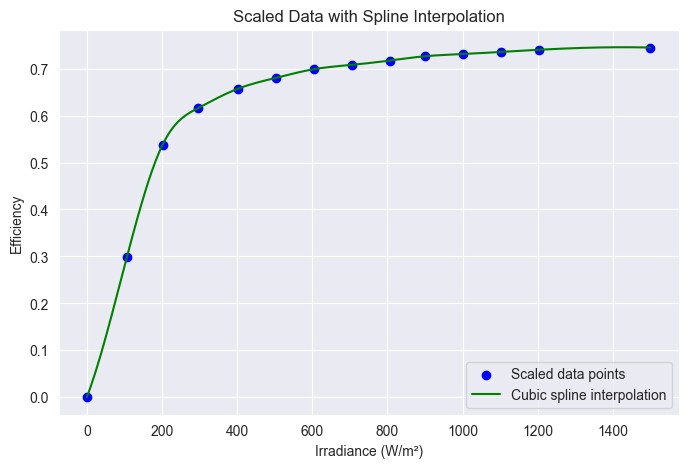

Estimated efficiency at 484.073401 W/m²: 0.6765613856938038


In [130]:
def scale_values(value, old_min, old_max, new_min, new_max):
    return (value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

# Scale the data
x_vals = np.array(list(unscaled_irrad_eff.keys()))
y_vals = np.array(list(unscaled_irrad_eff.values()))
x_vals_scaled = scale_values(x_vals, 0, 253, 0, 1500)
y_vals_scaled = scale_values(y_vals, 0, 174, 0.0, 0.8)

# Create cubic spline interpolator
spline_interpolator = interp1d(x_vals_scaled, y_vals_scaled, kind='cubic', fill_value="extrapolate")

# Function to estimate efficiency given irradiance
def estimate_efficiency(irradiance):
    return spline_interpolator(irradiance)

# Plot the scaled data and the spline
x_line = np.linspace(min(x_vals_scaled), max(x_vals_scaled), 500)
y_line = spline_interpolator(x_line)

plt.figure(figsize=(8, 5))
plt.scatter(x_vals_scaled, y_vals_scaled, color='blue', label='Scaled data points')
plt.plot(x_line, y_line, color='green', label='Cubic spline interpolation')
plt.title('Scaled Data with Spline Interpolation')
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('Efficiency')
plt.legend()
plt.grid(True)
plt.show()


estimated_thermal_efficiency = estimate_efficiency(daily_irradiance)
print(f"Estimated efficiency at {daily_irradiance} W/m²: {estimated_efficiency}")

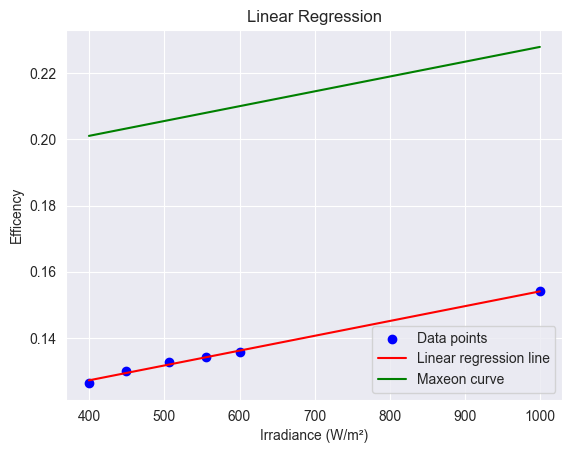

In [123]:
# https://ieeexplore.ieee.org/abstract/document/6861716
unscaled_pv_irrad_eff = {
    221: 245,
    248: 252,
    280: 257,
    307: 260,
    332: 263
}

# Function to scale values from one range to another
def scale_values(value, old_min, old_max, new_min, new_max):
    # Scaling a value from an old range to a new range
    return (value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

# Converting keys and values to numpy arrays for efficient computation
x_pv_px_vals = np.array(list(unscaled_pv_irrad_eff.keys()))
y_pv_px_vals = np.array(list(unscaled_pv_irrad_eff.values()))

# Scaling the x and y values to the desired ranges
x_pv_vals = [item[0] for item in scale_values(x_pv_px_vals, 0, 332, 0, 600).reshape(-1, 1)]
y_pv_vals = scale_values(y_pv_px_vals, 0, 349, 0.0, 0.18)

# Using the previously defined variables
x_vals_reshaped = np.array(x_pv_vals).reshape(-1, 1)
model = LinearRegression()
model.fit(x_vals_reshaped, y_pv_vals)

# Predict y values for the regression line
y_pred = model.predict(x_vals_reshaped)

eff_at_1000 = model.predict(np.array([[1000]]))[0]
x_pv_vals = np.append(x_pv_vals, 1000)
y_pv_vals = np.append(y_pv_vals, eff_at_1000)
y_ext_pred = model.predict(np.array(x_pv_vals).reshape(-1, 1))

shift = .228 - eff_at_1000 # https://maxeon.com/us/sites/default/files/2024-03/sp_max6_66c_res_440_435_425_dc_ds_en_ltr_552142.pdf
maxeon_curve = y_ext_pred + shift

# Plotting the data points
plt.scatter(x_pv_vals, y_pv_vals, color='blue', label='Data points')

# Plotting the regression line
plt.plot(x_pv_vals, y_ext_pred, color='red', label='Linear regression line')
plt.plot(x_pv_vals, maxeon_curve, color='green', label='Maxeon curve')

# Adding labels and legend
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('Efficency')
plt.title('Linear Regression')
plt.legend()

# Display the plot
plt.show()

In [131]:
maxeon_at_482 = model.predict(np.array([[daily_irradiance]]))[0] + shift
maxeon_at_482

0.20488249670886174

In [271]:
# Given values
raptor_daily_harvest = 129000  # in Wh
raptor_speed = 5.25  # in m/s
target_speed = 3.0  # in m/s

# Calculate power used at the original speed (in Watts)
power_original_w = raptor_daily_harvest / 24  # Convert Wh to W by dividing by hours in a day

# Calculate the power required at the desired speed using the cubic relationship (search: v3)
power_required_w = power_original_w * (target_speed / raptor_speed) ** 3

daily_energy_output_m2 = daily_irradiance * maxeon_at_482 * 24
propulsion_energy_req = power_required_w * 24

propulsion_panel_area = propulsion_energy_req / daily_energy_output_m2

panel_h = 1.872 # m
panel_w = 1.032
panel_area = panel_h * panel_w
panel_weight = 20.9 # kg
panel_kg_per_m2 = panel_weight / panel_area
propulsion_energy_weight = panel_kg_per_m2 * propulsion_panel_area

battery_density = 500 # Wh/kg
storage_capacity = 4146 # Wh, ~v1.6
battery_weight = storage_capacity / battery_density

electric_weight = battery_weight + propulsion_energy_weight
electric_weight


117.68990105477448

[0.6718445850038959, 0.6868305141541698, 0.701123497001831, 0.7147166653791474, 0.7276091862946793, 0.7398056827923782, 0.7513156168284468]


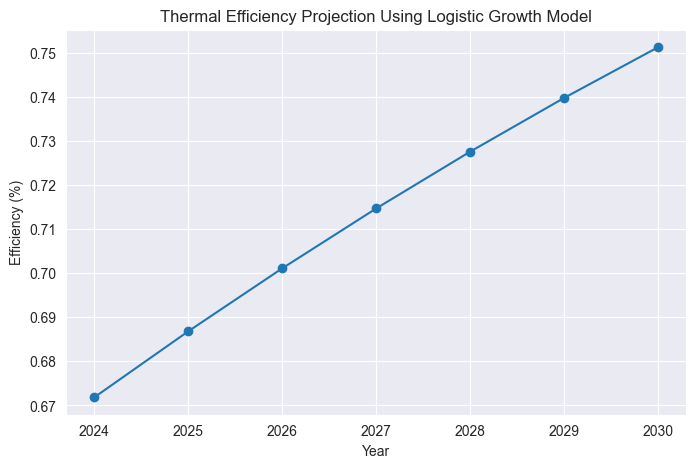

In [147]:
# Parameters (0.6765613856938038)
L = .90  # https://www.osti.gov/biblio/1090218
k = 0.09  # https://www.sciencedirect.com/science/article/abs/pii/S0960148114001451
t_0 = 2012
start_year = 2024
end_year = 2030

# Years
years = np.arange(start_year, end_year + 1)

# Logistic growth model function
def logistic_growth(t, L, k, t_0):
    return L / (1 + np.exp(-k * (t - t_0)))

# Calculate efficiencies for each year
efficiencies = [logistic_growth(t, L, k, t_0) for t in years]
print(efficiencies)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(years, efficiencies, marker='o')
plt.title('Thermal Efficiency Projection Using Logistic Growth Model')
plt.xlabel('Year')
plt.ylabel('Efficiency (%)')
plt.grid(True)
plt.show()

In [152]:
thermal_eff_2030 = efficiencies[-1]
print(thermal_eff_2030)
csp_wh_per_m2 = daily_irradiance * thermal_eff_2030 * 24
csp_ann_gj_per_m2 = csp_wh_per_m2 * 3.6e-6 * 365
csp_ann_t_co2_per_m2 = csp_ann_gj_per_m2 / thermal_requirement_2030
csp_ann_t_co2_per_m2

0.7513156168284468


4.224452281135052

In [254]:
adsorption_ir_midpt = 0.1172984
kg_sorbent_per_ton_co2 = 7.5 # (g adsorbent / kg co2 captured) * (1000 / 1000); from https://iopscience.iop.org/article/10.1088/2516-1083/abf1ce/pdf
kg_sorbent_2030 = kg_sorbent_per_ton_co2 * (1 - contactor_improvement_rate) ** (2030 - 2021)
monolith_ratio = 0.2
kg_monolith_per_ton_co2 = kg_sorbent_2030 * monolith_ratio
kg_contactor_per_ton_co2 = kg_sorbent_2030 + kg_monolith_per_ton_co2

contactor_kg_per_m2_csp = kg_contactor_per_ton_co2 * csp_ann_t_co2_per_m2
contactor_kg_per_m2_csp

18.812782250670548

In [189]:
csp_frame_kg_per_m2 = 15.0 # https://www.osti.gov/biblio/1888029
csp_mirror_kg_per_m2 = 7.5
csp_weight_kg = csp_frame_kg_per_m2 + csp_mirror_kg_per_m2
csp_weight_kg

22.5

In [286]:
# Constants and conversions
g_co2_capture_per_min_per_m2_csp = csp_ann_t_co2_per_m2 * 1000 * 1000 / (365 * 24 * 60)
molar_mass_co2 = 44.01  
molar_volume_at_stp = 22.4
cycle_time = 16 # minutes

moles_co2_per_minute = g_co2_capture_per_min_per_m2_csp / molar_mass_co2
stp_liter_per_cycle = moles_co2_per_minute * molar_volume_at_stp * cycle_time

slp_kpa = 101.325
press_at_5400m = slp_kpa * (1 - 0.12) ** (5400/1000)
liter_per_cycle_at_5400m = stp_liter_per_cycle * slp_kpa / press_at_5400m

hdpe_density = 0.95  # density in g/cm^3
wall_thickness_cm = 0.5  # wall thickness in cm (5 mm)
ratio_diameter_height = 3.5 / 27.5  # inner diameter to height ratio

# Convert volume from liters to cubic centimeters
volume_cm3 = liter_per_cycle_at_5400m * 1000  # 1 liter = 1000 cm^3

# Calculate the inner height (H) of the cylinder using the cubic root
# Rearranged formula: H = [(4 * V) / (π * ratio^2)]^(1/3)
inner_height_cm = ((4 * volume_cm3) / (math.pi * (ratio_diameter_height ** 2))) ** (1/3)
inner_diameter_cm = inner_height_cm * ratio_diameter_height

# Calculate the outer dimensions
outer_diameter_cm = inner_diameter_cm + 2 * wall_thickness_cm
outer_height_cm = inner_height_cm + 2 * wall_thickness_cm

# Calculate the volume of the material used
# Volume of HDPE = Volume of outer cylinder - Volume of inner cylinder
volume_hdpe_cm3 = (math.pi * (outer_diameter_cm/2)**2 * outer_height_cm) - volume_cm3

# Calculate the mass of HDPE needed
tank_kg_per_m2_csp = (hdpe_density * volume_hdpe_cm3) / 1000  # converting grams to kilograms
tank_kg_per_m2_csp


9.742685416030508

In [266]:
battery_density_2019 = 250 # https://vimeo.com/389506892?utm_campaign=2470763&utm_source=affiliate&utm_channel=affiliate&cjevent=c37b9631eb7411ee82ea00660a82b839&clickid=c37b9631eb7411ee82ea00660a82b839
quail_storage_capacity = 4146 # Wh
quail_battery_weight = quail_storage_capacity / battery_density_2019

quail_panel_area = 4.6
quail_panel_weight = quail_panel_area * panel_kg_per_m2
print(quail_panel_weight)
quail_electric_weight = quail_battery_weight + quail_panel_weight
print(quail_electric_weight)

quail_max_lifting_weight = 261.2
quail_unpowered_weight = quail_max_lifting_weight - quail_electric_weight
quail_unpowered_weight


49.764377526005426
66.34837752600542


194.85162247399455

In [204]:
T0 = 288.15  # Sea level standard temperature in Kelvin
P0 = 101325  # Sea level standard pressure in Pascals
g = 9.80665  # Acceleration due to gravity in m/s^2
L = 0.0065  # Temperature lapse rate in K/m
R = 287.058  # Specific gas constant for dry air in J/(kg*K)

# Calculate the temperature at the given altitude
T = T0 - L * 5400

# Apply the barometric formula
P = P0 * (T / T0) ** (g / (L * R))
P

51194.78641956336

In [205]:
T = T0 - L * 5400
T

253.04999999999998

In [219]:
# Constants
g = const.g  # Acceleration due to gravity (m/s^2)
M_air = 28.97e-3  # Molar mass of air (kg/mol)
M_hydrogen = 2.016e-3  # Molar mass of hydrogen (kg/mol)

density_air = (P * M_air) / (const.R * T)

# Calculate the density of hydrogen at the given altitude
density_hydrogen = (P * M_hydrogen) / (const.R * T)
density_diff = density_air - density_hydrogen

quail_envelope_vol = 2713
mass_lifted = quail_envelope_vol * density_diff
mass_lifted

1779.3370692832655

In [284]:
kg_per_m2_csp = csp_weight_kg + mass_hdpe_kg + contactor_kg_per_m2_csp

available_lifted_mass = mass_lifted - quail_unpowered_weight 
non_electric_payload = available_lifted_mass - electric_weight

m2_csp = non_electric_payload / kg_per_m2_csp
print(m2_csp)

total_co2_capture = m2_csp * csp_ann_t_co2_per_m2
total_co2_capture


28.729450787327846


121.36619391428432

In [262]:
federal_45q_credit = 180 # $/ton
net_credit = federal_45q_credit * (1 - embodied_material_emissions)
print(net_credit)
storage_ir = 0.0497563
scus_cost_2021 = 16.0 # ocean (ship) https://www.sciencedirect.com/science/article/pii/S2772970223000032
scus_cost_2030 = scus_cost_2021 * (1 - storage_ir) ** (2030 - 2021)
costs["opex"]["aero"]["scus"] = scus_cost_2030
costs["capex"]["aero"]["storage"] = 13.53
total_aero_cost = sum(costs["capex"]["aero"].values()) + sum(costs["opex"]["aero"].values())
print(total_aero_cost)
airship_budget = net_credit - total_aero_cost
airship_budget

165.2079294
90.6563765745413


74.55155282545871

In [272]:
q_cells_m2 = 1722 * 1134 / 1000000 # https://ressupply.com/q-cells?sort=p.price&order=DESC
q_cells_price_2024 = 315.0
solar_pv_ir = .09
q_cells_price_2030 = q_cells_price_2024 * (1 - solar_pv_ir) ** (2030 - 2024)
q_cells_price_per_m2_2030 = q_cells_price_2030 / q_cells_m2
q_cells_price_per_m2_2030

battery_price_2030 = 80.0 # $/kWh https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/#:~:text=Technological%20innovation%20and%20manufacturing%20improvement,and%20%2480%2FkWh%20in%202030.
battery_cost_2030 = quail_storage_capacity / 1000 * battery_price_2030
quail_power_cost = (quail_panel_area * q_cells_price_per_m2_2030) + battery_cost_2030
quail_power_cost

flight_vehicle_cost = 10000 # https://www.pcworld.com/article/428013/two-years-on-googles-project-loon-drifts-into-focus.html
balloon_and_flight_cost = flight_vehicle_cost - quail_power_cost
balloon_and_flight_cost

9246.943280521906

In [298]:
aero_pv_cost = propulsion_panel_area * q_cells_price_per_m2_2030
print(f"PV panel cost in 2030: ${aero_pv_cost:.2f} ({propulsion_panel_area:.2f} m² of PV panels, {q_cells_price_per_m2_2030:.2f} $/m²)")
aero_battery_cost = battery_cost_2030
print(f"Battery cost in 2030: ${aero_battery_cost:.2f} ({quail_storage_capacity:.2f} Wh battery, {battery_price_2030:.2f} $/kWh)")

csp_panel_cost_per_m2 = 152.0 # https://www.nrel.gov/docs/fy21osti/77829.pdf
csp_panel_cost = csp_panel_cost_per_m2 * m2_csp
print(f"CSP cost in 2030: ${csp_panel_cost:.2f} ({m2_csp:.2f} m² of CSP panels, {csp_panel_cost_per_m2:.2f} $/m²)")

rhdpe_price_lb = .76 # $/lb https://www.spglobal.com/commodityinsights/en/our-methodology/price-assessments/chemicals/us-recycled-hdpe
rhdpe_price_kg = rhdpe_price_lb * 2.20462
tank_weight_kg = tank_kg_per_m2_csp * m2_csp
unpressurized_store_m3 = liter_per_cycle_at_5400m * m2_csp / 1000
tank_cost = tank_weight_kg * rhdpe_price_kg
print(f"Tank cost in 2030: ${tank_cost:.2f} ({tank_weight_kg:.2f} kg of HDPE to store {unpressurized_store_m3:.2f} m³ of CO2)")



PV panel cost in 2030: $926.32 (10.11 m² of PV panels, 91.60 $/m²)
Battery cost in 2030: $331.68 (4146.00 Wh battery, 80.00 $/kWh)
CSP cost in 2030: $4366.88 (28.73 m² of CSP panels, 152.00 $/m²)
Tank cost in 2030: $468.98 (279.90 kg of HDPE to store 3.75 m³ of CO2)
